## Source-referenced edge variant
Verify if this variant of the circuit minimizes power or co-content

In [146]:
%reload_ext autoreload
%autoreload 2

from PySpice.Spice.Netlist import Circuit, SubCircuit
from PySpice.Spice.Parser import SpiceParser
from PySpice.Probe.WaveForm import WaveForm
from PySpice.Unit import *
import PySpice
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import ltspice
import os
from scipy.integrate import cumtrapz

### Co-content computation for NMOS

In [637]:
VGS = 1.5
Vmin = -0.6
Vmax = 5
sweep = np.arange(Vmin, Vmax, 0.0001)

In [638]:
# hack to plot 2 error curves at once - run cell below, save results, then change VG 
pwr_est_old = content_table + cocontent_table
pwr_old = I*V

In [639]:
# implement and verify co-content function for linear resistors
test_circuit = f"""
R1 D 0 {VG}
VD D 0 0
.dc VD {sweep.min()} {sweep.max()} {np.diff(sweep)[0]}
"""
with open('test.cir', 'w') as f:
    f.write(test_circuit)
os.system('/Applications/LTspice.app/Contents/MacOS/LTspice -b test.cir test.cir -o test.raw')

l = ltspice.Ltspice(f'test.raw')
l.parse()

I = l.get_data('I(R1)')
V = l.get_data('V(D)')
cocontent_table = cumtrapz(I, V, initial=0)
content_table = cumtrapz(V, I, initial=0)

# verify that content and co-content are half of power for linear resistors
# assert np.allclose(content_table, I * V / 2)
# print('content verified for linear resistors')

# assert np.allclose(cocontent_table, I * V / 2)
# print('co-content verified for linear resistors')

In [640]:
# pre-compute a table of co-content values for the transistor
test_circuit = f"""
M1 D G S S NMOS
VD D 0 0
VS S 0 0
VGS G S {VGS}
.model NMOS NMOS
.dc VD {sweep.min()} {sweep.max()} {np.diff(sweep)[0]}
"""
with open('test.cir', 'w') as f:
    f.write(test_circuit)
os.system('/Applications/LTspice.app/Contents/MacOS/LTspice -b test.cir test.cir -o test.raw')

l = ltspice.Ltspice(f'test.raw')
l.parse()

I = l.get_data('Id(M1)')
V = l.get_data('V(D)')

cocontent_table = cumtrapz(I, V, initial=0)
cocontent_table -= np.interp([0], V, cocontent_table)
content_table = cumtrapz(V, I, initial=0)
content_table -= np.interp([0], I, content_table)

def get_content_cocontent(VGS):
    test_circuit = f"""
    M1 D G 0 0 NMOS
    VD D 0 0
    * source-reference VGS
    VGS G S {VGS}
    .model NMOS NMOS
    .dc VD {sweep.min()} {sweep.max()} {np.diff(sweep)[0]}
    """
    with open('test.cir', 'w') as f:
        f.write(test_circuit)
    os.system('/Applications/LTspice.app/Contents/MacOS/LTspice -b test.cir test.cir -o test.raw')

    l = ltspice.Ltspice(f'test.raw')
    l.parse()

    I = l.get_data('Id(M1)')
    V = l.get_data('V(D)')

    cocontent_table = cumtrapz(I, V, initial=0)
    cocontent_table -= np.interp([0], V, cocontent_table)
    content_table = cumtrapz(V, I, initial=0)
    content_table -= np.interp([0], I, content_table)

    return content_table, cocontent_table, I, V

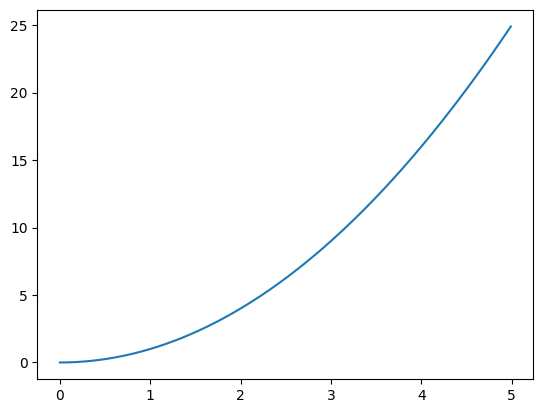

In [641]:
xs = np.arange(0, 5, 0.01)
ys = xs**2

plt.plot(xs, ys)

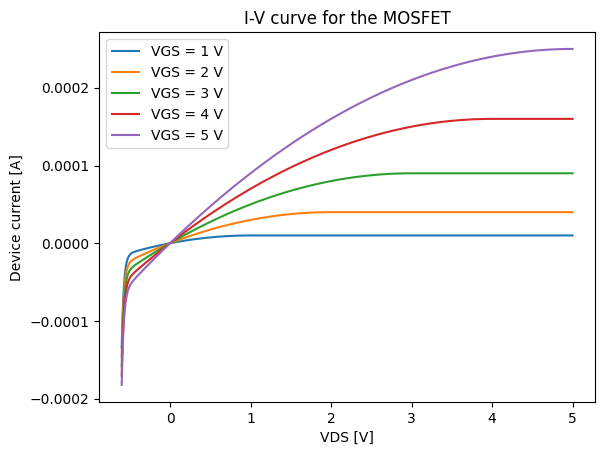

In [642]:
# I-V curve for the MOSFET
# plt.plot(V, I)
for gg in [1, 2, 3, 4, 5]:
    _, _, ii, vv = get_content_cocontent(gg)
    plt.plot(vv, ii, label=f'VGS = {gg} V')
plt.xlabel('VDS [V]')
plt.ylabel('Device current [A]')
plt.title('I-V curve for the MOSFET')
plt.legend()
plt.show()

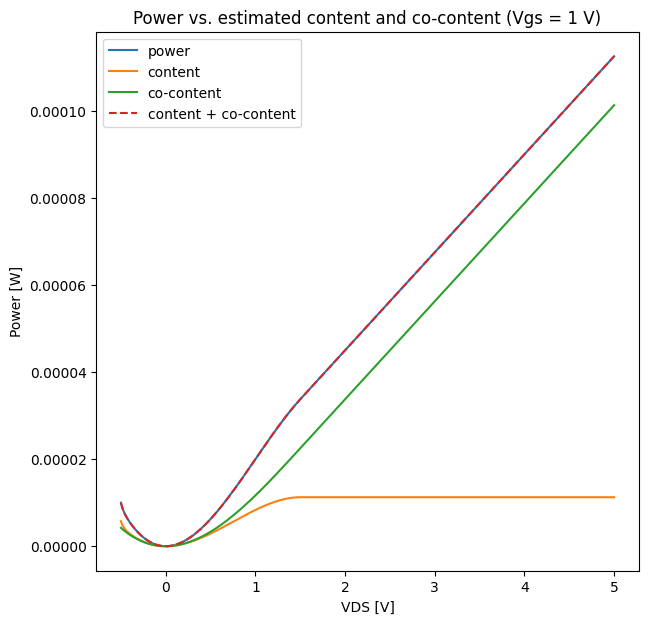

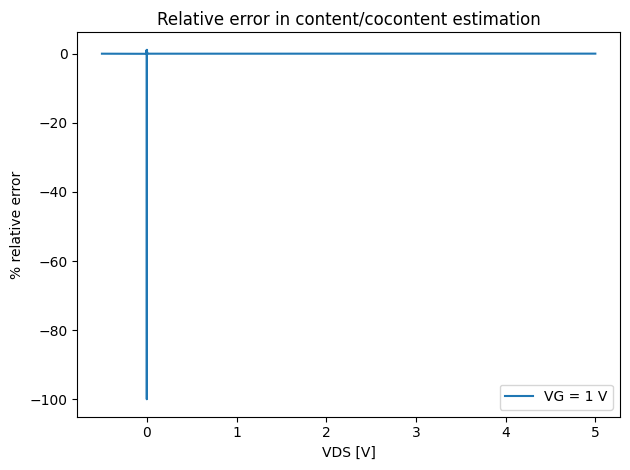

In [591]:
plt.figure(figsize=(7, 7))

# plt.subplot(1, 2, 1)
plt.plot(V, V*I, label='power')
plt.plot(V, content_table, label='content')
plt.plot(V, cocontent_table, label='co-content')
plt.plot(V, content_table + cocontent_table, label='content + co-content', linestyle='--')
plt.legend()
plt.xlabel('VDS [V]')
plt.ylabel('Power [W]')
plt.title(f'Power vs. estimated content and co-content (Vgs = {VG} V)')
plt.show()

# plt.subplot(1, 2, 2)
plt.plot(V, 100 * ((content_table + cocontent_table)-I*V) / (V*I), label='VG = 1 V')
# plt.plot(V, 100 * ((pwr_est_old)-pwr_old) / (pwr_old), label='VG = 5 V') # uncomment for 2-curve comparison

plt.xlabel('VDS [V]')
plt.ylabel('% relative error')
plt.title(f'Relative error in content/cocontent estimation')
# plt.title(f'Relative error in content/cocontent estimation (Vgs = {VG} V)')
plt.legend()

plt.tight_layout()
plt.show()

#### Counterexample to show that co-content isn't defined for ground-referenced transistors


In [592]:
name = 'counterexample'
counterexample_circuit = f"""
M1 D G 0 0 NMOS
VD D 0 0
VS S 0 0
VG G 0 {VG}
.model NMOS NMOS
.dc VS {sweep.min()} {sweep.max()} {np.diff(sweep)[0]}
"""
with open(f'{name}.cir', 'w') as f:
    f.write(test_circuit)
os.system(f'/Applications/LTspice.app/Contents/MacOS/LTspice -b {name}.cir {name}.cir -o {name}.raw')

l = ltspice.Ltspice(f'{name}.raw')
l.parse()

I1 = l.get_data('Id(M1)')
V1 = l.get_data('V(D,S)')

cocontent_table_1 = cumtrapz(I, V, initial=0)

offset = 0.5

counterexample_circuit = f"""
M1 D G 0 0 NMOS
VD D 0 {offset}
VS S 0 {offset}
VG G 0 {VG}
.model NMOS NMOS
.dc VS {sweep.min()} {sweep.max()} {np.diff(sweep)[0]}
"""
with open(f'{name}.cir', 'w') as f:
    f.write(test_circuit)
os.system(f'/Applications/LTspice.app/Contents/MacOS/LTspice -b {name}.cir {name}.cir -o {name}.raw')

l = ltspice.Ltspice(f'{name}.raw')
l.parse()

I1 = l.get_data('Id(M1)')
V1 = l.get_data('V(D,S)')

cocontent_table_1 = cumtrapz(I, V, initial=0)
content_table_2 = cumtrapz(V, I, initial=0)



## Computing whether power is minimized

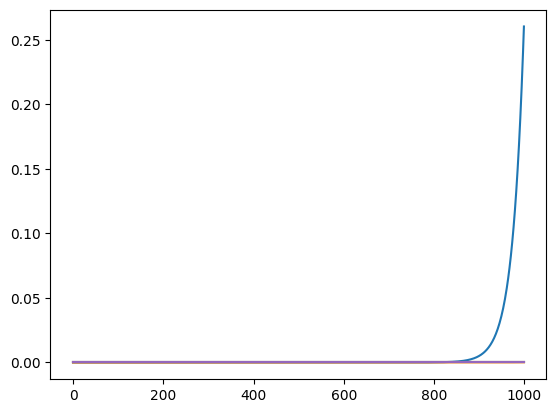

In [623]:
VG1 = 1
VG2 = 1.5
source_vals = np.linspace(0.2, 1, 5)
clamp_sweep = np.arange(0, 1, 0.001)

powers = []
co_contents = []
co_contents_m1 = []
co_contents_m2 = []
contents = []
source_powers = []
free_states = []
free_powers = []
free_co_contents = []
free_contents = []

m1_content, m1_cocontent, I1, V1 = get_content_cocontent(VG1)
m2_content, m2_cocontent, I2, V2 = get_content_cocontent(VG2)

for VS in source_vals:
    # clamp_sweep = np.arange(VS-.3, VS+., 0.001)

    circuit = f"""* /Users/lancemathias/Documents/LTspice/Draft11.asc
M1 N003 N005 N001 N001 NMOS
Vin N003 0 {VS}
M2 N001 N006 P001 P001 NMOS
Vout P001 0 0
VC N001 0 0
* Ground-referenced VG
* VG1 N005 0 {VG1}
* VG2 N006 0 {VG2}
* Source-referenced VG
VG1 N005 N001 {VG1}
VG2 N006 P001 {VG2}
.model NMOS NMOS
.model PMOS PMOS
.lib /Users/lancemathias/Library/Application Support/LTspice/lib/cmp/standard.mos
.dc VC {clamp_sweep.min()} {clamp_sweep.max()} {np.diff(clamp_sweep)[0]}
"""
    with open('test.cir', 'w') as f:
        f.write(circuit)
    os.system('/Applications/LTspice.app/Contents/MacOS/LTspice -b test.cir test.cir -o test.raw')

    l = ltspice.Ltspice(f'test.raw')
    l.parse()

    # p = l.get_data('V(N003,N001)')*l.get_data('Id(M1)') + l.get_data('V(N001,P001)')*l.get_data('Id(M2)')
    p = l.get_data('V(N003,N001)')*l.get_data('Id(M1)') + l.get_data('V(N001,P001)')*l.get_data('Id(M2)') - l.get_data('I(VC)')*l.get_data('V(N001)') #+ l.get_data('I(Vin)')*l.get_data('V(N003)')
    plt.plot(-l.get_data('I(VC)')*l.get_data('V(N001)'))
    cocontent = np.interp(l.get_data('V(N001,P001)'), V2, m2_cocontent) + np.interp(l.get_data('V(N003,N001)'), V1, m1_cocontent)
    # content = np.interp(l.get_data('Id(M1)'), I1, m1_content) + np.interp(l.get_data('Id(M2)'), I2, m2_content)
    content = np.interp(l.get_data('Id(M1)'), I1, m1_content) + np.interp(l.get_data('Id(M2)'), I2, m2_content) - l.get_data('I(VC)')*l.get_data('V(N001)') #+ l.get_data('I(Vin)')*l.get_data('V(N003)')

    # assert all measured values are within the range of the table
    # assert all(l.get_data('Id(M1)') <= I1.max())
    # assert all(l.get_data('Id(M2)') <= I2.max())
    # assert all(l.get_data('V(N001,P001)') <= V2.max())
    # assert all(l.get_data('V(N003,N001)') <= V1.max())

    # assert all(l.get_data('Id(M1)') >= I1.min())
    # assert all(l.get_data('Id(M2)') >= I2.min())
    # assert all(l.get_data('V(N001,P001)') >= V2.min())
    # assert all(l.get_data('V(N003,N001)') >= V1.min())

    sp = -l.get_data('V(N001)')*l.get_data('I(VC)')
    powers.append(p)
    contents.append(content)
    co_contents.append(cocontent)
    co_contents_m1.append(np.interp(l.get_data('V(N003,N001)'), V1, m1_cocontent))
    co_contents_m2.append(np.interp(l.get_data('V(N001,P001)'), V2, m2_cocontent))
    source_powers.append(sp)

    circuit_2 = f"""* /Users/lancemathias/Documents/LTspice/Draft11.asc
M1 N003 N005 N001 N001 NMOS
Vin N003 0 {VS}
M2 N001 N006 P001 P001 NMOS
Vout P001 0 0
* Ground-referenced VG
* VG1 N005 0 {VG1}
* VG2 N006 0 {VG2}
* Source-referenced VG
VG1 N005 N001 {VG1}
VG2 N006 P001 {VG2}
.model NMOS NMOS
.model PMOS PMOS
.lib /Users/lancemathias/Library/Application Support/LTspice/lib/cmp/standard.mos
.op
.backanno
.end
"""
    with open('test.cir', 'w') as f:
        f.write(circuit_2)
    os.system('/Applications/LTspice.app/Contents/MacOS/LTspice -b test.cir test.cir -o test.raw')

    l = ltspice.Ltspice(f'test.raw')
    l.parse()

    free_states.append(l.get_data('V(N001)'))
    free_powers.append(l.get_data('V(N003,N001)')*l.get_data('Id(M1)') + l.get_data('V(N001,P001)')*l.get_data('Id(M2)'))
    free_co_contents.append(np.interp(l.get_data('V(N001,P001)'), V2, m2_cocontent) + np.interp(l.get_data('V(N003,N001)'), V1, m1_cocontent))
    free_contents.append(np.interp(l.get_data('Id(M1)'), I1, m1_content) + np.interp(l.get_data('Id(M2)'), I2, m2_content))

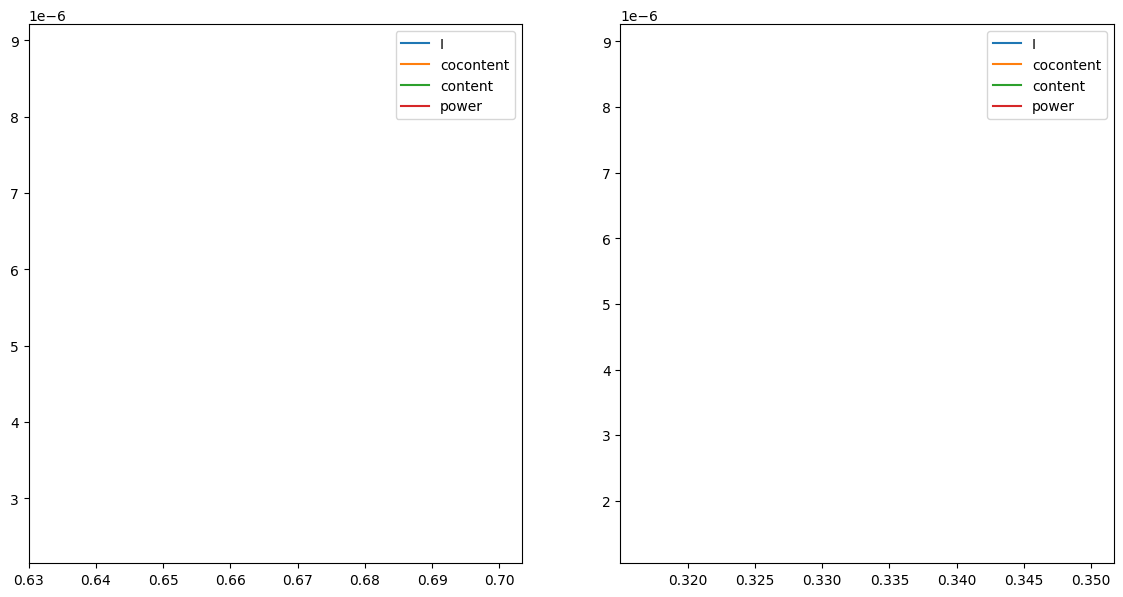

In [624]:
# plot V, I, cocontent, content, power for each transistor
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
# plt.plot(l.get_data('V(N003,N001)'), label='V')
plt.plot(l.get_data('V(N003,N001)'), l.get_data('Id(M1)'), label='I')
plt.plot(l.get_data('V(N003,N001)'), np.interp(l.get_data('V(N003,N001)'), V1, m1_cocontent), label='cocontent')
plt.plot(l.get_data('V(N003,N001)'), np.interp(l.get_data('Id(M1)'), I1, m1_content), label='content')
plt.plot(l.get_data('V(N003,N001)'), l.get_data('V(N003,N001)')*l.get_data('Id(M1)'), label='power')
plt.legend()

plt.subplot(1, 2, 2)
# plt.plot(l.get_data('V(N001,P001)'), label='V')
plt.plot(l.get_data('V(N001,P001)'), l.get_data('Id(M2)'), label='I')
plt.plot(l.get_data('V(N001,P001)'), np.interp(l.get_data('V(N001,P001)'), V2, m2_cocontent), label='cocontent')
plt.plot(l.get_data('V(N001,P001)'), np.interp(l.get_data('Id(M2)'), I2, m2_content), label='content')
plt.plot(l.get_data('V(N001,P001)'), l.get_data('V(N001,P001)')*l.get_data('Id(M2)'), label='power')
plt.legend()


In [625]:
dp = np.diff(powers, axis=1)
stationary_inds_p = np.argmin(np.abs(dp), axis=1)

dJ = np.diff(co_contents, axis=1)
stationary_inds_J = np.argmin(np.abs(dJ), axis=1)

dG = np.diff(contents, axis=1)
stationary_inds_G = np.argmin(np.abs(dG), axis=1)

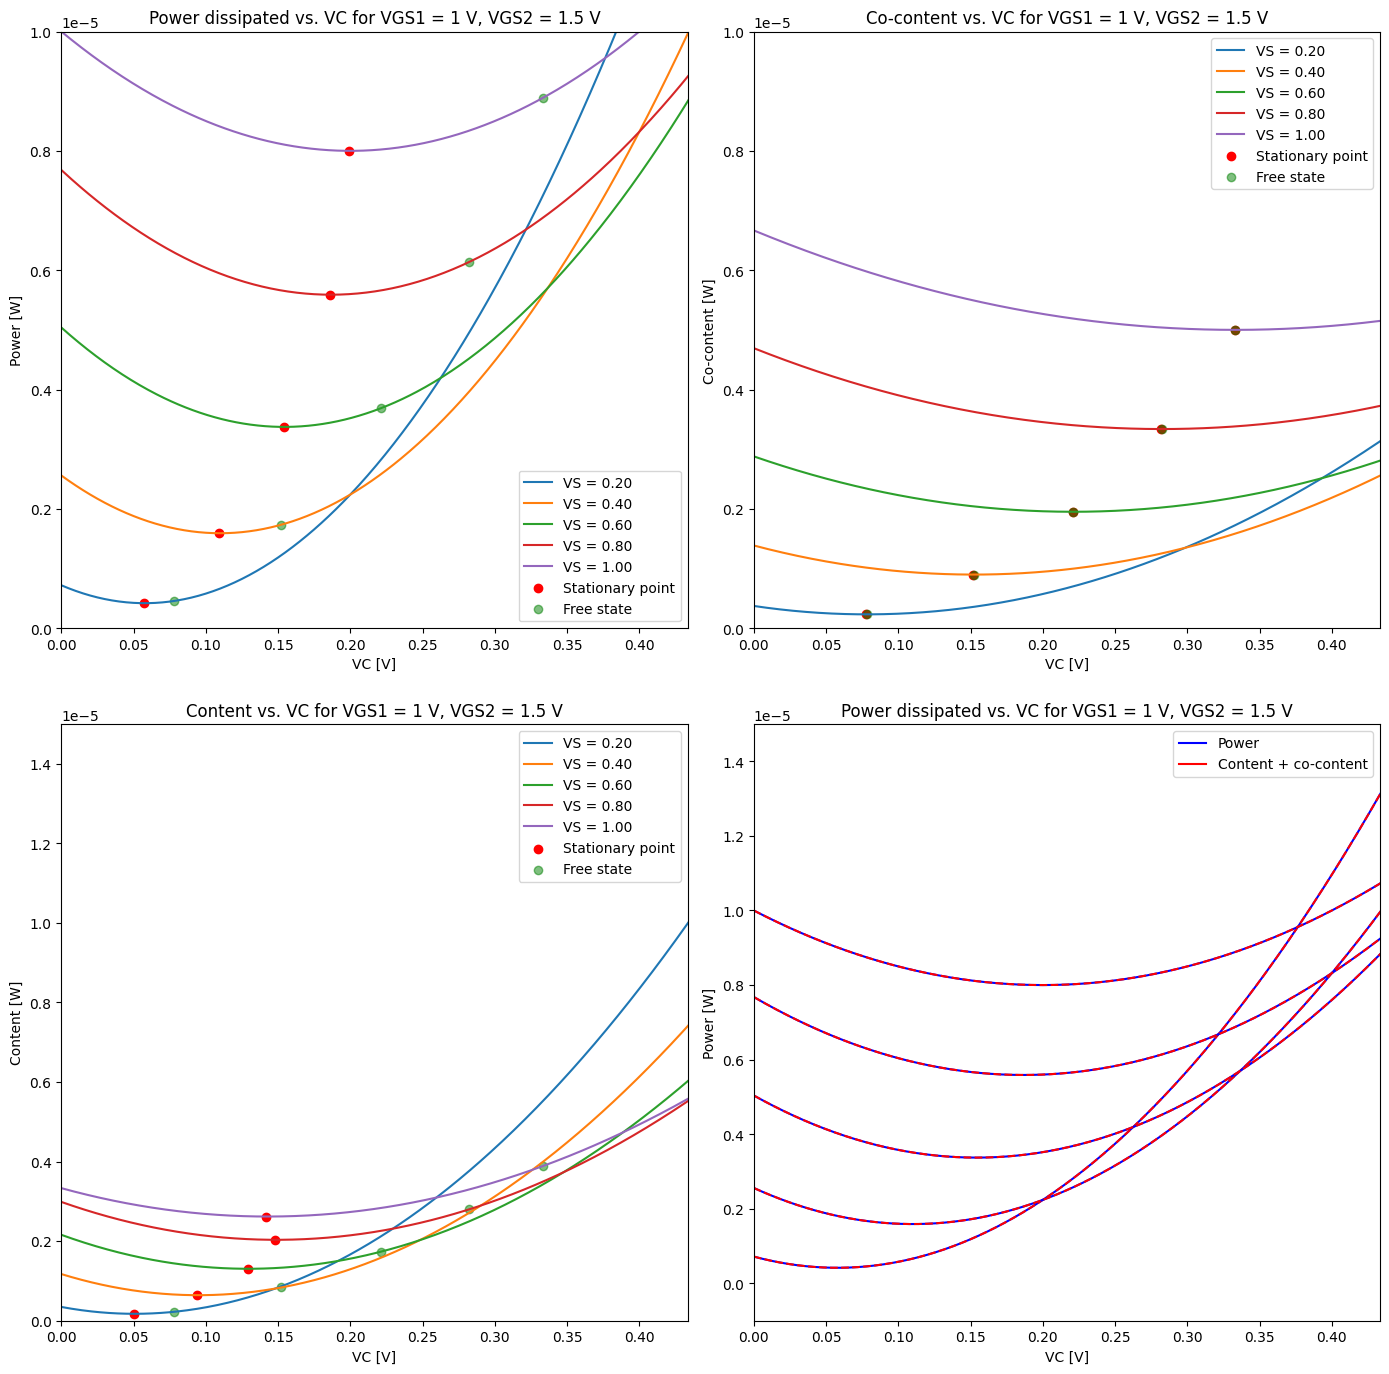

In [627]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 2, 1)
for i in range(0, len(powers), 1):
    plt.plot(clamp_sweep, powers[i], label=f'VS = {source_vals[i]:.2f}')

plt.scatter(clamp_sweep[stationary_inds_p], [powers[i][stationary_inds_p][i] for i in range(len(powers))], c='r', label='Stationary point')
plt.scatter(free_states, free_powers, c='g', label='Free state', alpha=0.5)

plt.ylim(0, 1e-5) 
plt.xlim(0, max(max(free_states), max(clamp_sweep[stationary_inds_p])) + 0.1)
plt.legend()
plt.title(f'Power dissipated vs. VC for VGS1 = {VG1} V, VGS2 = {VG2} V')
plt.xlabel('VC [V]')
plt.ylabel('Power [W]')

plt.subplot(2, 2, 2)
for i in range(0, len(powers), 1):
    plt.plot(clamp_sweep, co_contents[i], label=f'VS = {source_vals[i]:.2f}')

plt.scatter(clamp_sweep[stationary_inds_J], [co_contents[i][stationary_inds_J][i] for i in range(len(co_contents))], c='r', label='Stationary point')
plt.scatter(free_states, free_co_contents, c='g', label='Free state', alpha=0.5)
plt.legend()
plt.title(f'Co-content vs. VC for VGS1 = {VG1} V, VGS2 = {VG2} V')
plt.xlabel('VC [V]')
plt.ylabel('Co-content [W]')
plt.xlim(0, max(max(free_states), max(clamp_sweep[stationary_inds_J])) + 0.1)
plt.ylim(-0e-6, 1e-5)

plt.subplot(2, 2, 3)
for i in range(0, len(powers), 1):
    plt.plot(clamp_sweep, contents[i], label=f'VS = {source_vals[i]:.2f}')

plt.scatter(clamp_sweep[stationary_inds_G], [contents[i][stationary_inds_G][i] for i in range(len(contents))], c='r', label='Stationary point')
plt.scatter(free_states, free_contents, c='g', label='Free state', alpha=0.5)
plt.legend()
plt.title(f'Content vs. VC for VGS1 = {VG1} V, VGS2 = {VG2} V')
plt.xlabel('VC [V]')
plt.ylabel('Content [W]')
plt.xlim(0, max(max(free_states), max(clamp_sweep[stationary_inds_G])) + 0.1)
plt.ylim(-0e-6, 1.5e-5)

plt.subplot(2, 2, 4)
# draw number line
# plt.plot([0, max(clamp_sweep[stationary_inds_p])], [0, 0], c='k', linewidth=1)
# plt.scatter(clamp_sweep[stationary_inds_p], np.zeros_like([powers[i][stationary_inds_p][i] for i in range(len(powers))]), c='r', label='Power minimizing points')
# plt.scatter(clamp_sweep[stationary_inds_G], np.zeros_like([co_contents[i][stationary_inds_G][i] for i in range(len(co_contents))]), c='b', label='Co-content minimizing points', alpha=0.5)
# plt.legend()
# plt.title(f'Stationary points for VG1 = {VG1} V, VG2 = {VG2} V')
# plt.ylabel('Power [W]')
# plt.xlabel('VC [V]')

for i in range(0, len(powers), 1):
    plt.plot(clamp_sweep, powers[i], c='b')
    # plt.plot(clamp_sweep, co_contents[i], c='r')
    plt.plot(clamp_sweep, contents[i]+co_contents[i], c='r', linestyle='--')

plt.plot([], [], c='b', label='Power')
plt.plot([], [], c='r', label='Content + co-content')

plt.legend()
plt.title(f'Power dissipated vs. VC for VGS1 = {VG1} V, VGS2 = {VG2} V')
plt.xlabel('VC [V]')
plt.ylabel('Power [W]')
plt.xlim(0, max(max(free_states), max(clamp_sweep[stationary_inds_G])) + 0.1)
plt.ylim(-1e-6, 1.5e-5)
# plt.ylim(-0e-6, 1.5e-5)

plt.tight_layout()
plt.show()